In [1]:
import nltk
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [2]:
data = pd.read_csv('news_summary_more.csv')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [4]:
# 중복샘플 확인

print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
# 중복샘플 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('중복 제거 후 전체 샘플수 :', (len(data)))

중복 제거 후 전체 샘플수 : 98360


In [6]:
# null데이터 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


텍스트의 최소 토큰 개수 : 1
텍스트의 최대 토큰 개수 : 66
텍스트의 평균 토큰 개수 : 58.23730174867833
요약의 최소 토큰 개수 : 1
요약의 최대 토큰 개수 : 18
요약의 평균 토큰 개수 : 9.553629524196827


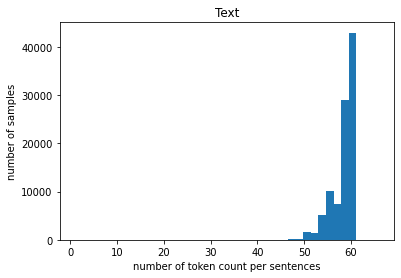

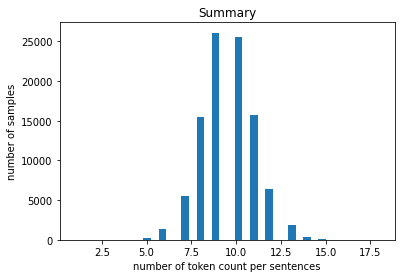

In [7]:
# 전처리 전 원문 및 요약문의 토큰 개수 시각화
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 토큰 개수 : {}'.format(np.min(text_len)))
print('텍스트의 최대 토큰 개수 : {}'.format(np.max(text_len)))
print('텍스트의 평균 토큰 개수 : {}'.format(np.mean(text_len)))
print('요약의 최소 토큰 개수 : {}'.format(np.min(headlines_len)))
print('요약의 최대 토큰 개수 : {}'.format(np.max(headlines_len)))
print('요약의 평균 토큰 개수 : {}'.format(np.mean(headlines_len)))

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('number of token count per sentences')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(headlines_len, bins = 40)
plt.xlabel('number of token count per sentences')
plt.ylabel('number of samples')
plt.show()

In [8]:
# 영어 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
# 불용어 다운로드
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수(소문자화, html태그 제거, 소괄호 안 문자열 제거, 
# 쌍따옴표 제거, 약어 정규화, 소유격 제거, 영어 외 문자열 제거, 기타)
def preprocess_sentence(sentence, remove_stopwords=True):
    
    sentence = sentence.lower()
    sentence=BeautifulSoup(sentence, 'lxml').text
    sentence=re.sub(r'\([^)]*\)', '', sentence)
    sentence=re.sub('"', '', sentence)
    sentence=' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence=re.sub(r"'s\b", "", sentence)
    sentence=re.sub("[^a-zA-Z]", " ", sentence)
    sentence=re.sub('[m]{2,}', 'mm', sentence)
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') and len(word) > 1)
    else :
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [13]:
# 전체 text 데이터에 대한 전처리
clean_text = []

for t in data['text']:
    t = preprocess_sentence(t)
    clean_text.append(t)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [14]:
# 전체 요약문 데이터에 대한 전처리
clean_headlines = []

for h in data['headlines']:
    h = preprocess_sentence(h)
    clean_headlines.append(h)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_headlines[:5])

Text 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


In [15]:
#데이터프레임 데이터를 전처리된 데이터로 변경
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [16]:
# null 데이터 유무 확인
data.isnull().sum()

# null 데이터 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


텍스트의 최소 토큰 개수 : 1
텍스트의 최대 토큰 개수 : 60
텍스트의 평균 토큰 개수 : 35.09968483123221
요약의 최소 토큰 개수 : 1
요약의 최대 토큰 개수 : 13
요약의 평균 토큰 개수 : 7.136183407889386


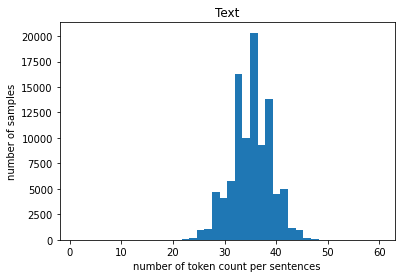

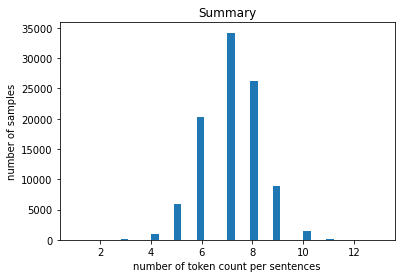

In [17]:
# 전처리 후 원문 및 요약문의 토큰 개수 시각화
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 토큰 개수 : {}'.format(np.min(text_len)))
print('텍스트의 최대 토큰 개수 : {}'.format(np.max(text_len)))
print('텍스트의 평균 토큰 개수 : {}'.format(np.mean(text_len)))
print('요약의 최소 토큰 개수 : {}'.format(np.min(headlines_len)))
print('요약의 최대 토큰 개수 : {}'.format(np.max(headlines_len)))
print('요약의 평균 토큰 개수 : {}'.format(np.mean(headlines_len)))

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('number of token count per sentences')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(headlines_len, bins = 40)
plt.xlabel('number of token count per sentences')
plt.ylabel('number of samples')
plt.show()

In [18]:
# 전체 샘플의 원하는 비율을 커버할 수 있는 토큰 개수 확인
def find_max_len_for_coverage(coverage_ratio, nested_list):
    lengths = sorted([len(s.split()) for s in nested_list])  # 모든 문장의 단어 개수를 정렬
    max_len = lengths[int(len(lengths) * coverage_ratio) - 1]  # 90%에 해당하는 길이 선택
    print(f'{int(coverage_ratio * 100)}%의 샘플을 커버하는 최대 길이: {max_len}')
    return max_len

In [19]:
find_max_len_for_coverage(0.9, data['text'])
find_max_len_for_coverage(0.9, data['headlines'])

90%의 샘플을 커버하는 최대 길이: 40
90%의 샘플을 커버하는 최대 길이: 9


9

In [20]:
# 지정된 토큰 개수로 커버 가능한 샘플 비율 확인

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [21]:
text_max_len = 40
headlines_max_len = 8

In [22]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.8925782838552258


In [23]:
# 원문과 요약문 데이터프레임을 max_len 기준으로 자르기

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

In [24]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 81914


In [25]:
# 시작 토큰과 종료 토큰 추가

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
6,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
7,govt directs alok verma join work day retirement,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma join work day...,govt directs alok verma join work day retireme...
9,cong wins ramgarh bypoll rajasthan takes total...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll rajasthan ta...,cong wins ramgarh bypoll rajasthan takes total...


In [26]:
# 넘파이 배열로 변환
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [27]:
# 검증데이터 인덱스 지정
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 16382


In [28]:
# 검증데이터 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 65532
훈련 레이블의 개수 : 65532
테스트 데이터의 개수 : 16382
테스트 레이블의 개수 : 16382


In [29]:
# 인코더 입력문 전처리
# 토크나이징
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [30]:
# 등장빈도 7회 미만을 기준 등장빈도 및 희귀단어 수량 확인
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61699
등장 빈도가 6번 이하인 희귀 단어의 수: 41837
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19862
단어 집합에서 희귀 단어의 비율: 67.80823027925898
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.790873118581267


In [31]:
# 원문 단어집합 중 약 68%의 희귀단어 제외시킨 2만개 토큰으로 설정
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 2만개로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[7337, 9434, 9224, 12162, 9225, 1634, 1726, 2057, 1482, 666, 10714, 1706, 2352, 1268, 864, 21, 129, 1172, 1634, 9224, 2567, 581, 347, 1072, 4936, 136, 3515, 2742, 1676, 1532, 2341, 9224, 205, 317, 2057, 2384, 56, 7570], [251, 277, 552, 425, 3725, 3668, 1364, 132, 1, 383, 3668, 175, 21, 1927, 2580, 1114, 112, 6156, 2580, 1114, 492, 1042, 48, 72, 382, 2000, 6398, 2, 3668, 37, 1669, 888, 2508], [4, 1051, 2772, 352, 286, 27, 816, 448, 281, 1975, 707, 352, 5312, 71, 306, 4, 2797, 871, 583, 7338, 4101, 146, 1165, 539, 6241, 4431, 355, 468, 4, 646, 2772, 352, 286, 27, 816]]


In [33]:
# 디코더 입력문(타겟) 전처리
# 토크나이징
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [34]:
# 등장빈도 5회 미만을 기준 등장빈도 및 희귀단어 수량 확인

threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27149
등장 빈도가 4번 이하인 희귀 단어의 수: 16801
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10348
단어 집합에서 희귀 단어의 비율: 61.884415632251645
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.614172177488768


In [35]:
# 타겟문장 단어집합 중 약 62%의 희귀단어 제외시킨 1만개 토큰으로 설정

tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 5937, 7730, 8419, 585, 2378, 980, 1139], [1, 1970, 2316, 53, 753, 113, 2379, 501], [1, 3, 38, 2890, 259, 1451, 19, 1176], [1, 6, 2610, 2538, 3541, 661, 149, 24, 1879], [1, 87, 154, 4566, 333, 231, 1451, 687]]
target
decoder  [[5937, 7730, 8419, 585, 2378, 980, 1139, 2], [1970, 2316, 53, 753, 113, 2379, 501, 2], [3, 38, 2890, 259, 1451, 19, 1176, 2], [6, 2610, 2538, 3541, 661, 149, 24, 1879, 2], [87, 154, 4566, 333, 231, 1451, 687, 2]]


In [36]:
# 원문의 토큰 개수가 5개이면 원문으로써의 의미가 있는가?
# 희소단어 제거 후 인코더 입력문 토큰 최소 6개 미만 존재 여부 확인

drop_encoder_train = [index for index, sentence in enumerate(encoder_input_train) if len(sentence) < 6]

print('토큰 6개 미만 원문 데이터의 개수 :', len(drop_encoder_train))

토큰 6개 미만 원문 데이터의 개수 : 1


In [37]:
drop_encoder_train

[41]

In [38]:
# 삭제할 문장 확인
for i, sentence in enumerate(encoder_input_train):
    if i == 41:
        print("문장 인덱스 :", i)
        print("시퀀스 배열 : ", sentence)

문장 인덱스 : 41
시퀀스 배열 :  [2776]


In [39]:
# drop_encoder_train 문장을 텍스트로 출력
src_tokenizer.index_word.get(2776, "<UNK>")

'text'

In [40]:
# 입력/출력 데이터셋에서 해당 문장 삭제

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_encoder_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_encoder_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_encoder_train]

In [41]:
# 희소단어 제거 후 디코더 입력문 및 타겟문 토큰 최소 2개 미만 존재 여부 확인

drop_decoder_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) < 2]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) < 2]

print('삭제할 훈련 데이터의 개수 :', len(drop_decoder_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0


In [42]:
# 입력/출력 데이터셋에서 해당 문장 삭제

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_decoder_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_decoder_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_decoder_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 65530
훈련 레이블의 개수 : 65530
테스트 데이터의 개수 : 16382
테스트 레이블의 개수 : 16382


In [43]:
# 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

In [44]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [45]:
# LSTM으로 모델 설계

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.2, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.2)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

In [46]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
#dec_emb = Embedding(tar_vocab, embedding_dim)(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [47]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [48]:
from tensorflow.keras.layers import AdditiveAttention

In [49]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [50]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# 콜백 설정
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)  # 조기 종료
mc = ModelCheckpoint('newsSumm_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)  # 최고 성능 모델 저장

# 모델 학습
history = model.fit(
    x=[encoder_input_train, decoder_input_train],
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=256,
    callbacks=[es, mc],  # ModelCheckpoint 추가
    epochs=50
)

Epoch 1/50
256/256 [==============================] - 27s 76ms/step - loss: 6.7557 - val_loss: 6.3147

Epoch 00001: val_loss improved from inf to 6.31471, saving model to newsSumm_best_model.h5
Epoch 2/50
256/256 [==============================] - 19s 73ms/step - loss: 6.2851 - val_loss: 5.8931

Epoch 00002: val_loss improved from 6.31471 to 5.89309, saving model to newsSumm_best_model.h5
Epoch 3/50
256/256 [==============================] - 19s 75ms/step - loss: 5.6663 - val_loss: 5.4374

Epoch 00003: val_loss improved from 5.89309 to 5.43743, saving model to newsSumm_best_model.h5
Epoch 4/50
256/256 [==============================] - 20s 76ms/step - loss: 5.1550 - val_loss: 5.1418

Epoch 00004: val_loss improved from 5.43743 to 5.14182, saving model to newsSumm_best_model.h5
Epoch 5/50
256/256 [==============================] - 20s 78ms/step - loss: 4.7470 - val_loss: 4.9687

Epoch 00005: val_loss improved from 5.14182 to 4.96875, saving model to newsSumm_best_model.h5
Epoch 6/50
256

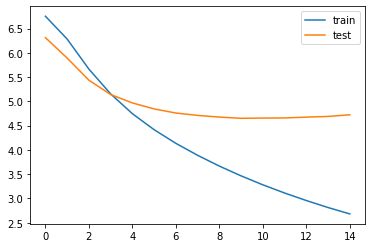

In [51]:
# 학습과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [52]:
# 인퍼런스 모델 구현
#정수 -> 단어, 단어 -> 정수 복원 기능 변수 선정

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [53]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [54]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))

# 학습모델 어텐션 구조와 비교
#attn_layer = AdditiveAttention(name='attention_layer')
#attn_out = attn_layer([decoder_outputs, encoder_output3])
#decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [55]:
# 단어 시퀀스 출력을 위한 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [56]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if i not in [0, 1, 2]:
            temp = temp + src_index_to_word[i]+' '
    return temp

In [57]:
# 50개 샘플 테스트
for i in range(50):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : music composer singer pritam said would want auction guitar gifted shah rukh khan charity srk wrote instagram gifted pritam jab harry met sejal shooting pritam gifted film beautiful music return pass would put auction charity commented pritam 
실제 요약 : wife reached bhargava denying officer indonesia 
예측 요약 :  happy late legend priyanka chopra


원문 : punjab government set target planting two crore saplings across state year green mission state forest minister sadhu singh said state government planning acquire land alongside roads plant saplings plantation maintenance saplings would handed concerned panchayats schools 
실제 요약 : play girl rejected government exists wrote crore 
예측 요약 :  delhi government approves crore diwali


원문 : former india captain mahendra singh dhoni ex australian opener matthew hayden participate six hitting contest chidambaram stadium chennai saturday competition take place ahead inaugural match tamil nadu premier league second edition dhoni players face bowlin

In [58]:
# 추출적 요약과 비교

from summa.summarizer import summarize

In [59]:
# 비교 테스트에 쓸 뉴스 샘플
test_list= ["The United Nations has announced that it will hold an emergency meeting to discuss the humanitarian crisis in Gaza. The meeting comes after several countries called for immediate action to address the worsening conditions. UN officials stated that they are deeply concerned about the lack of food, water, and medical supplies in the region.",
            "Scientists at Harvard University have developed a new type of battery that can charge in under five minutes. The battery uses a special lithium-ion technology that enhances conductivity and reduces heating issues. Researchers believe that this breakthrough could revolutionize the electric vehicle industry by making charging times comparable to refueling gas-powered cars.",
            "The global economy is expected to grow by 3.2% this year, according to the latest report by the International Monetary Fund. The report highlights that while growth remains steady in developed countries, emerging markets are experiencing fluctuations due to geopolitical tensions and supply chain disruptions. Economists warn that inflation could impact consumer spending in the coming months.",
            "Lionel Messi led his team to victory in the latest championship match, scoring two goals and assisting another. Fans cheered as the star player delivered an outstanding performance, securing a 3-1 win for his team. With this victory, Messi's team has advanced to the final round of the tournament.",
            "Apple has unveiled its latest iPhone model, featuring an improved camera system and a longer-lasting battery. The new device includes a more powerful processor, enabling faster performance and enhanced AI capabilities. Apple executives stated that the phone is designed to offer the best user experience yet."]

In [60]:
# 테스트 입력문 숫자 시퀀스로 변환
encoded_test_list = src_tokenizer.texts_to_sequences(test_list)

In [67]:
# 패딩 후 array 변환
encoded_test_list = pad_sequences(encoded_test_list, maxlen=text_max_len, padding='post')
encoded_test_list = np.array(encoded_test_list)

In [68]:
encoded_test_list

array([[  401,   689,    84,  1097,   903,   381,  2450,  4962,  1429,
         6676,   381,    54,   155,   316,    67,  2229,   304,  1503,
        16146,  1555,   473,    74,   568,  3971,  2647,  1484,   363,
          285,   424,  4789,   741,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [  701,  4960,   259,   567,    27,  3076,  2309,   934,    90,
          508,  2309,  1765,   360, 11248, 10422,   206, 12622, 13073,
          644,   262,  1042, 10018,    86,   804,   685,   596,   244,
         2479,   209,  1575,  2384,   836,     0,     0,     0,     0,
            0,     0,     0,     0],
       [  450,  1118,   455,  2734,     3,    57,  1565,   141,   115,
         3421,   665,   141,  9685,   793,  1504, 12438,   567,   316,
         6092,  2040, 11491,   102,  2660,  1983,  1642,  7651, 15200,
         7932,  2968,    86,  1715,  1637,  2651,   994,   173,     0,
            0,     0,     0,     0],
       [ 3061,  1962,   137,    47,  

In [81]:
#추출요약 결과 얻기
result_summa = []

for i, text in enumerate(test_list):

    # 추출 요약
    result_summa.append(summarize(text, words=40))


 Example 1
원문: The United Nations has announced that it will hold an emergency meeting to discuss the humanitarian crisis in Gaza. The meeting comes after several countries called for immediate action to address the worsening conditions. UN officials stated that they are deeply concerned about the lack of food, water, and medical supplies in the region.

 Example 2
원문: Scientists at Harvard University have developed a new type of battery that can charge in under five minutes. The battery uses a special lithium-ion technology that enhances conductivity and reduces heating issues. Researchers believe that this breakthrough could revolutionize the electric vehicle industry by making charging times comparable to refueling gas-powered cars.

 Example 3
원문: The global economy is expected to grow by 3.2% this year, according to the latest report by the International Monetary Fund. The report highlights that while growth remains steady in developed countries, emerging markets are experiencing

In [82]:
result_summa

['The United Nations has announced that it will hold an emergency meeting to discuss the humanitarian crisis in Gaza.\nThe meeting comes after several countries called for immediate action to address the worsening conditions.',
 'Scientists at Harvard University have developed a new type of battery that can charge in under five minutes.\nThe battery uses a special lithium-ion technology that enhances conductivity and reduces heating issues.',
 'The global economy is expected to grow by 3.2% this year, according to the latest report by the International Monetary Fund.\nThe report highlights that while growth remains steady in developed countries, emerging markets are experiencing fluctuations due to geopolitical tensions and supply chain disruptions.',
 "Lionel Messi led his team to victory in the latest championship match, scoring two goals and assisting another.\nWith this victory, Messi's team has advanced to the final round of the tournament.",
 'Apple has unveiled its latest iPhone

In [72]:
#decode_sequence(encoded_test_list[1].reshape(1, -1))

' ai develops device detect electricity'

In [84]:
#추상요약 결과 얻기
result_seq2seq = []

for i, text in enumerate(encoded_test_list):

    # 추상 요약
    result_seq2seq.append(decode_sequence(text.reshape(1, -1)))

In [85]:
result_seq2seq

[' us embassy agree un drills',
 ' ai develops device detect electricity',
 ' india ranks global global global programme imf',
 ' messi play messi play football match',
 ' apple unveils iphone screen screen']

In [87]:
# 요약 결과 비교를 위한 데이터프레임 생성
result_df = pd.DataFrame({'추출 요약': result_summa, '추상 요약': result_seq2seq})
result_df

,추출 요약,추상 요약
0,The United Nations has announced that it will ...,us embassy agree un drills
1,Scientists at Harvard University have develope...,ai develops device detect electricity
2,The global economy is expected to grow by 3.2%...,india ranks global global global programme imf
3,Lionel Messi led his team to victory in the la...,messi play messi play football match
4,"Apple has unveiled its latest iPhone model, fe...",apple unveils iphone screen screen


### 결론
 - 모델 성능이 웬만큼 좋지 않으면 추상 요약이 추출 요약보다 오히려 안좋음
 - 동일 단어가 중복되는 현상 발견(ex. global global global)